In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
df = pd.read_csv('merged_output.csv')
df['label'] = df['label'].replace({
    'Sit2': 'Sit'
})

df['label'] = df['label'].replace(r'(BackFall\d+|FrontFall\d+)', 'Fall', regex=True)


In [5]:
df.sample(7)

,accX,accY,accZ,gyroX,gyroY,gyroZ,timestamp,label
2731,640,16344,2724,-873,-406,-1451,170038,Steady
225,1084,13552,6592,683,-1668,53,117816,Walk
3485,172,15640,-3656,-549,-188,-1266,37659,Sit
3273,-172,-3268,18772,512,-139,-1922,116173,Fall
465,2000,12228,4444,-1470,237,3574,241107,Walk
670,-3024,4044,-14452,-534,-448,-1402,7822,Sleep
3791,152,15728,-3928,-799,-275,-1290,191841,Sit


In [6]:
print(f"Total rows: {len(df)}")
print("Activity Counts:")
print(df['label'].value_counts())
print("\nSample of the raw data:")
print(df.head())

Total rows: 3988
Activity Counts:
label
Sit       1147
Walk       662
Steady     607
Stand      601
Sleep      559
Fall       412
Name: count, dtype: int64

Sample of the raw data:
   accX   accY  accZ  gyroX  gyroY  gyroZ  timestamp label
0 -2880  12256  4164    242    488  -4628       4429  Walk
1 -2972  15840  6144   -407  -1217  -2754       5522  Walk
2 -4188  20860  6344    912   2898  -4023       6022  Walk
3  3936  17468  1788  -2558  -1033  -1065       6522  Walk
4 -1208  13544   360   -751  -4306  -1545       7022  Walk


### Remove Noise

In [8]:
sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']
window_size = 5 # This is a hyperparameter you can tune

for col in sensor_cols:
    # The 'min_periods=1' handles the edges of the data where a full window isn't available
    df[col + '_filtered'] = df[col].rolling(window=window_size, min_periods=1).mean()

print("\n--- Noise Reduction Applied ---")
print("Sample of data with filtered columns:")
print(df[['accX', 'accX_filtered', 'label']].head())


--- Noise Reduction Applied ---
Sample of data with filtered columns:
   accX  accX_filtered label
0 -2880   -2880.000000  Walk
1 -2972   -2926.000000  Walk
2 -4188   -3346.666667  Walk
3  3936   -1526.000000  Walk
4 -1208   -1462.400000  Walk


### EDA

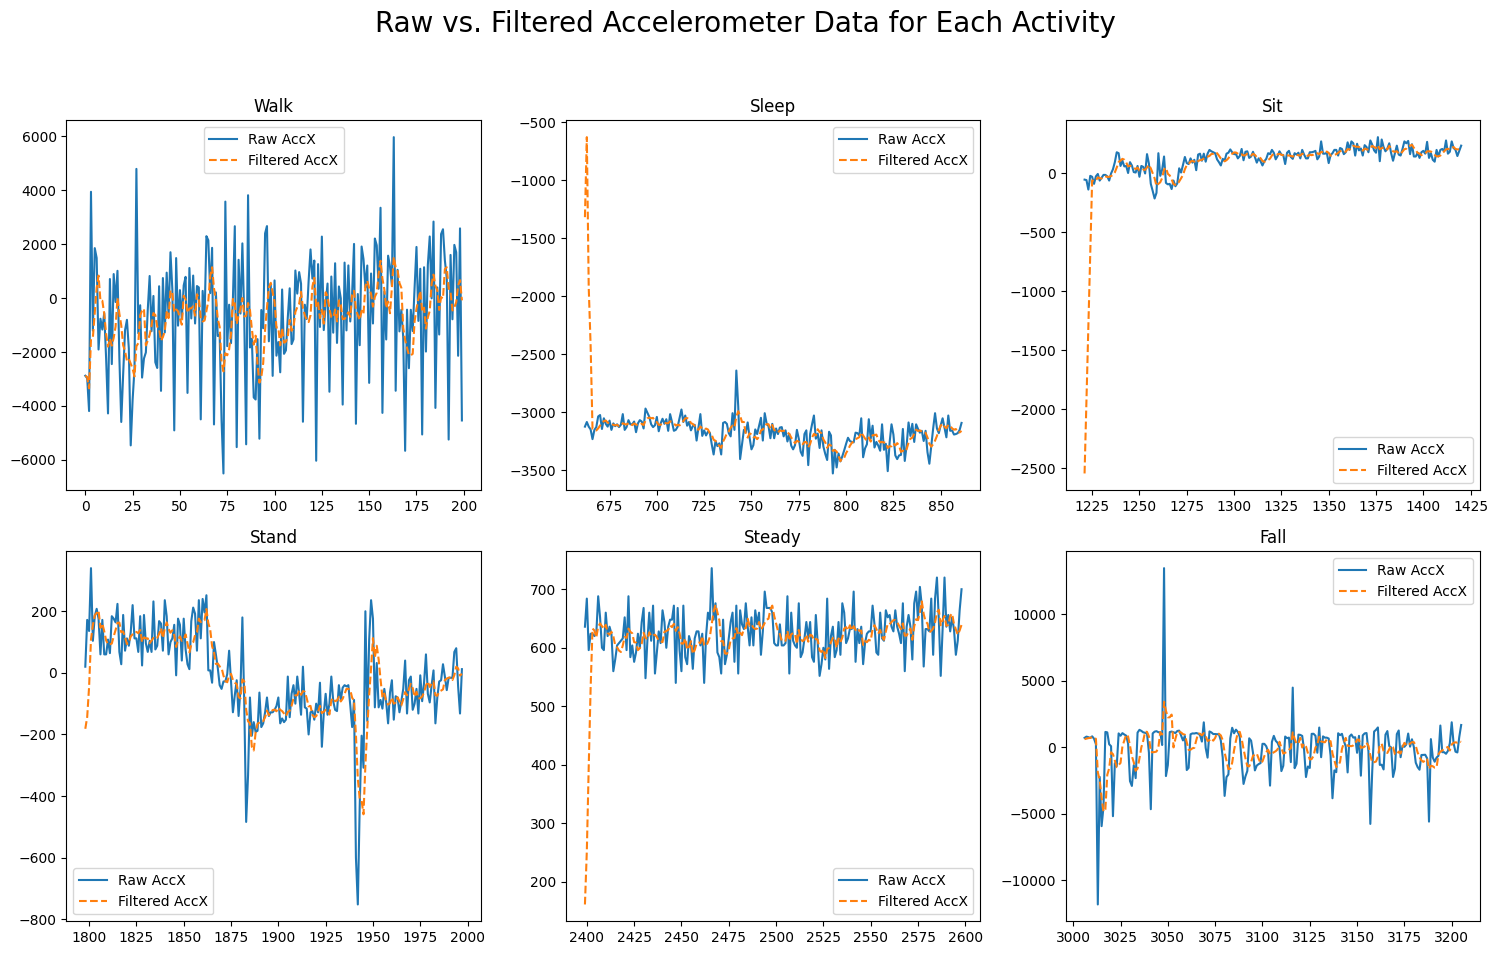

In [10]:
plt.figure(figsize=(15, 10))
plt.suptitle("Raw vs. Filtered Accelerometer Data for Each Activity", fontsize=20)
unique_labels = df['label'].unique()

for i, label in enumerate(unique_labels):
    plt.subplot(2, 3, i + 1)
    subset = df[df['label'] == label].head(200)
    plt.plot(subset['accX'], label='Raw AccX')
    plt.plot(subset['accX_filtered'], label='Filtered AccX', linestyle='--')
    plt.title(label)
    plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Feature Extraction

In [13]:
# --- 4. Feature Extraction (Corrected) ---
# ----------------------------------------------------------------

# The sampling rate is 2 samples per second (2Hz).
SAMPLING_RATE = 2

# We'll use a 2-second window to capture an activity.
# Window size in samples = 2 seconds * 2 samples/second = 4 samples.
TIME_STEPS = 4

# We'll use a 1-second step, which gives a 50% overlap.
# Step size in samples = 1 second * 2 samples/second = 2 samples.
STEP_SIZE = 2

features = []
labels = []
filtered_cols = [col + '_filtered' for col in sensor_cols]

for i in range(0, len(df) - TIME_STEPS, STEP_SIZE):
    window_data = df[filtered_cols].iloc[i : i + TIME_STEPS]
    window_labels = df['label'].iloc[i : i + TIME_STEPS]

    # The label for the window is the one that appears most often
    # FIX APPLIED HERE: Using pandas' built-in mode() function
    current_label = window_labels.mode()[0]
    
    # Calculate statistical features for each sensor in the window
    feature_row = []
    for sensor in filtered_cols:
        feature_row.append(window_data[sensor].mean())
        feature_row.append(window_data[sensor].std())
        feature_row.append(window_data[sensor].min())
        feature_row.append(window_data[sensor].max())
        feature_row.append(np.sqrt(np.mean(window_data[sensor]**2))) # Root Mean Square
    
    features.append(feature_row)
    labels.append(current_label)

# Convert to a new DataFrame
feature_columns = []
for sensor in sensor_cols:
    for stat in ['mean', 'std', 'min', 'max', 'rms']:
        feature_columns.append(f"{sensor}_{stat}")

df_features = pd.DataFrame(features, columns=feature_columns)
df_features['label'] = labels

print("\n--- Feature Extraction Complete (at 2Hz) ---")
print(f"Window size = {TIME_STEPS} samples, Step size = {STEP_SIZE} samples.")
print(f"Created {len(df_features)} feature windows.")
print("Sample of the new feature data:")
print(df_features.head())


--- Feature Extraction Complete (at 2Hz) ---
Window size = 4 samples, Step size = 2 samples.
Created 1992 feature windows.
Sample of the new feature data:
     accX_mean     accX_std     accX_min  accX_max     accX_rms     accY_mean  \
0 -2669.666667   790.832754 -3346.666667   -1526.0  2756.117277  14807.166667   
1 -1712.966667  1182.868064 -3346.666667    -516.8  1995.905169  16299.566667   
2  -193.600000  1014.151810 -1462.400000     830.4   899.365821  15874.400000   
3   248.000000   449.591459  -110.400000     830.4   461.631195  15815.600000   
4  -530.800000   576.903551 -1328.000000    -102.4   728.945759  15940.400000   

      accY_std  accY_min  accY_max      accY_rms  ...   gyroY_std  gyroY_min  \
0  2049.814544   12256.0   16606.0  14913.198498  ...  467.219323     -364.5   
1   250.509250   15993.6   16606.0  16301.010388  ...  779.667049     -949.4   
2   732.406881   14808.0   16416.0  15887.066760  ...  402.485722    -1518.0   
3   703.606405   14808.0   16416.0  1

### Model Building


--- Training Model ---
Model training complete.

Model Accuracy: 99.25%

Classification Report:
              precision    recall  f1-score   support

        Fall       0.95      0.98      0.96        41
         Sit       1.00      0.99      1.00       115
       Sleep       1.00      0.98      0.99        56
       Stand       1.00      1.00      1.00        60
      Steady       1.00      1.00      1.00        61
        Walk       0.99      1.00      0.99        66

    accuracy                           0.99       399
   macro avg       0.99      0.99      0.99       399
weighted avg       0.99      0.99      0.99       399



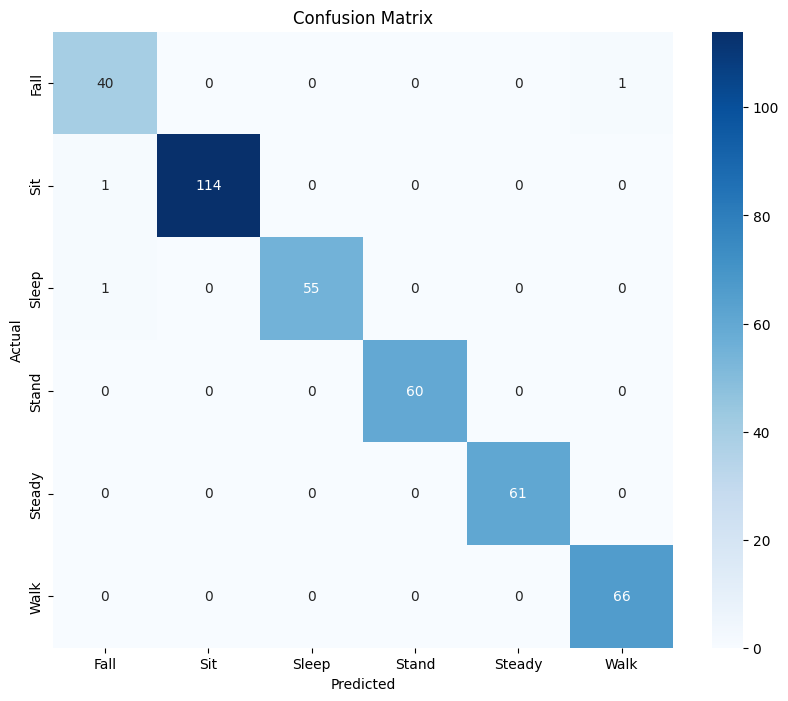

In [14]:
X = df_features.drop('label', axis=1)
y = df_features['label']

# Encode string labels to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\n--- Training Model ---")
model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
# Use le.classes_ to show original string labels in the report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [15]:
joblib.dump(model, "human_activity_model.pkl")
joblib.dump(le, "label_encoder.pkl")
print("\n--- Model and Label Encoder Saved ---")
print("Files created: 'human_activity_model.pkl' and 'label_encoder.pkl'")


--- Model and Label Encoder Saved ---
Files created: 'human_activity_model.pkl' and 'label_encoder.pkl'


In [23]:
sample_to_predict = X_test.iloc[310].values.reshape(1, -1)
sample_label_encoded = y_test[310]

# Use the loaded model to predict
predicted_label_encoded = model.predict(sample_to_predict)

# Decode the prediction back to the original string label
predicted_label = le.inverse_transform(predicted_label_encoded)
actual_label = le.inverse_transform([sample_label_encoded])

print("\n--- Sample Prediction Test ---")
print(f"Actual Activity: {actual_label[0]}")
print(f"Predicted Activity: {predicted_label[0]}")


--- Sample Prediction Test ---
Actual Activity: Stand
Predicted Activity: Stand


c:\Users\gsmlv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
